## Use rasterio to load several geotiffs into specified coordinate window and calculate statistics


In [1]:
import json
import fiona
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import rasterio # rasterio and OGR don't mix...see rasterio docs
from rasterio import Affine
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# list of files to read
fdir = "F:\\2017_Karen_Sandwich_maps\\"
fnames = (\
"2016-01-22_SandwichTNB_PT_DEM_10cm_trimmed.tif",\
"2016-01-25_SandwichTNB_DEM_10cm_trimmed.tif",\
"2016-02-11_SandwichTNB_DEM_10cm_trimmed.tif",\
"2016-03-30_SandwichTNB_AS_DEM_10cm_trimmed.tif",\
"2016-09-21_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-01-09_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-01-25_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-02-14_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-03-16_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-04-28_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-05-04_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-09-18_SandwichTNB_DEM_10cm_trimmed.tif",\
#"2018-01-03_SandwichTNB_DEM_10cm_trimmed.tif",\
"2018-01-10_SandwichTNB_DEM_10cm_trimmed.tif"\
)
# list of dates for use as titles / column headers
titles = ([\
         "22-Jan-2016",\
         "25-Jan-2016",\
         "11-Feb-2016",\
         "30-Mar-2016",\
         "21-Sep-2016",\
         "09-Jan-2017",\
         "25-Jan-2017",\
         "14-Feb-2017",\
         "16-Mar-2017",\
         "28-Apr-2017",\
         "04-May_2017",\
         "18-Sep-2017",\
#         "03-Jan-2017",\
         "10-Jan-2018"]
         )

### Load a window (subset) of the tif files
This will crash if the window is bigger than the dataset...the chosen window is almost the biggest one that will fit all of the data.

All of this would go faster if there was less unused space in matrices, which could be optimized by rotating the tifs to fit a rectangle betters, but this approach keeps everything in original NAD83 UTM Zone 19N meters.

Loading 13 files.
0
F:\2017_Karen_Sandwich_maps\2016-01-22_SandwichTNB_PT_DEM_10cm_trimmed.tif
xo,yo:  376286.64299908397 4625440.8344103005
xoff, yoff, xend, yend:  2013 10013 2408 9208
1
F:\2017_Karen_Sandwich_maps\2016-01-25_SandwichTNB_DEM_10cm_trimmed.tif
xo,yo:  376287.14850415837 4625434.75106331
xoff, yoff, xend, yend:  2008 10008 2347 9147
2
F:\2017_Karen_Sandwich_maps\2016-02-11_SandwichTNB_DEM_10cm_trimmed.tif
xo,yo:  376296.13149943855 4625448.832959766
xoff, yoff, xend, yend:  1918 9918 2488 9288
3
F:\2017_Karen_Sandwich_maps\2016-03-30_SandwichTNB_AS_DEM_10cm_trimmed.tif
xo,yo:  376292.3872081661 4625440.284709241
xoff, yoff, xend, yend:  1956 9956 2402 9202
4
F:\2017_Karen_Sandwich_maps\2016-09-21_SandwichTNB_DEM_10cm_trimmed.tif
xo,yo:  376232.5822683347 4625453.651816779
xoff, yoff, xend, yend:  2554 10554 2536 9336
5
F:\2017_Karen_Sandwich_maps\2017-01-09_SandwichTNB_DEM_10cm_trimmed.tif
xo,yo:  376323.5035454615 4625436.139639027
xoff, yoff, xend, yend:  1644 9644 23

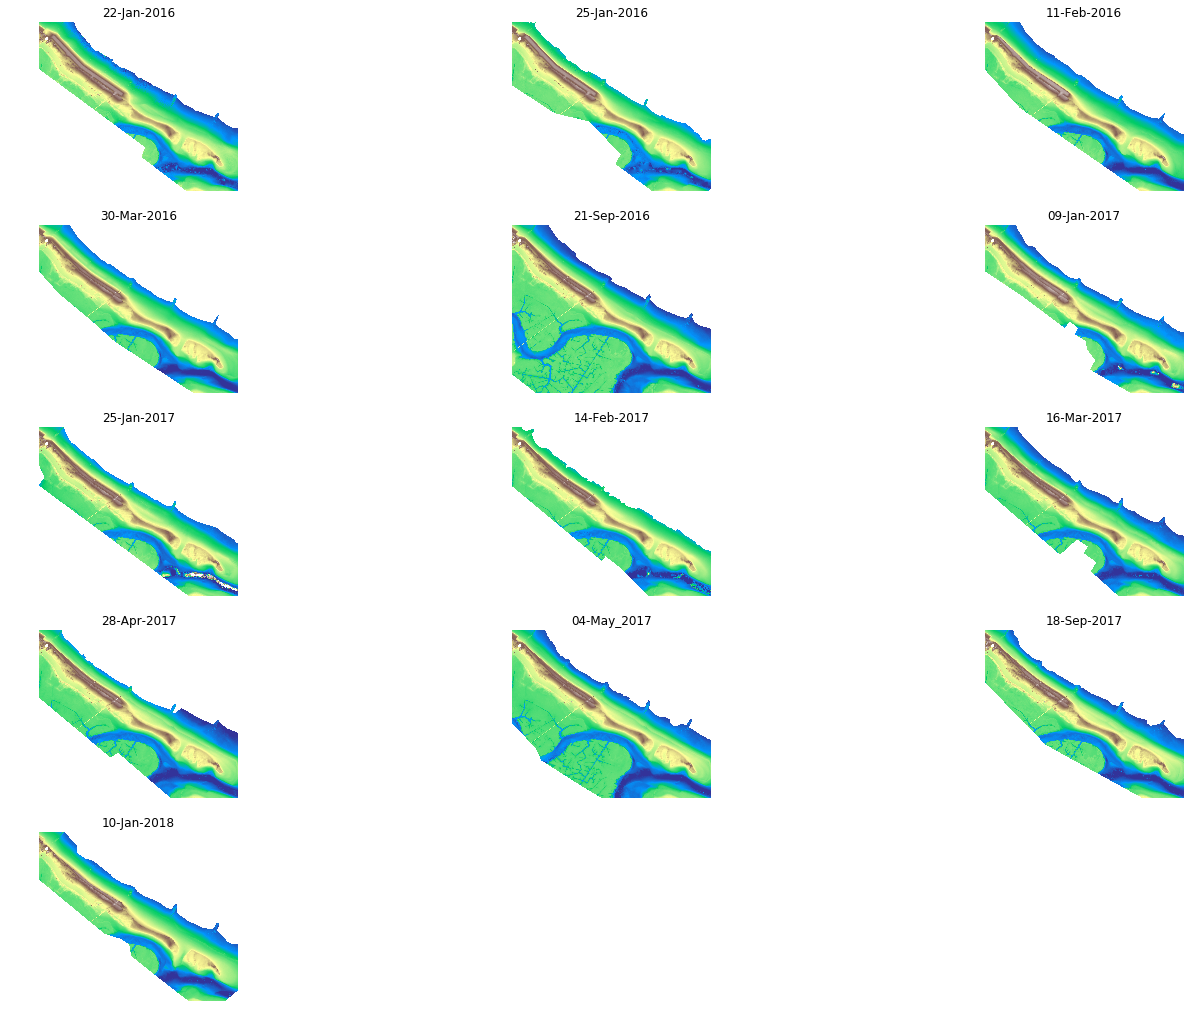

In [3]:
nf=len(fnames)
print("Loading {} files.".format(nf))

# top left corner of region of interest (UTM Zone 19N meters)
e0 = 376488.; n0 = 4625200.

# size of roi (colums, rows). divide by 10 to get meters
xsize, ysize = 8000, 6800

# initialize 3d array for data
zw = np.zeros((nf,ysize,xsize))

# declare a plot size
plt.subplots(figsize=(24,18))

# loop through the list of files
for i in range(nf):
    print(i)
    print(fdir+fnames[i])
    # open first time to determine origin
    with rasterio.open(fdir+fnames[i]) as src:
        # location of origin (upper left) from transform
        xo,yo = src.transform*(0,0)
        print('xo,yo: ',xo,yo)
        # index of first col, row in window from inverse transform
        xy = ~src.transform*(e0, n0)
        xoff, yoff = int(xy[0]), int(xy[1])
        print("xoff, yoff, xend, yend: ",xoff, xoff+xsize, yoff, yoff+ysize)
        src.close()
   
    # reopen and read band 1 (elevation...only band in these files) into specifed window
    with rasterio.open(fdir+fnames[i]) as src:
        # load into temporary 2d array
        # note the x,y switch: syntax for window=((row_start, row_stop)(col_start, col_stop)
        zt = src.read(1, window=((yoff,yoff+ysize),(xoff,xoff+xsize)))
        
        zt[zt<=-99]=np.nan
        # copy 2d array into slab of 3d array
        zw[i::]=zt
       
        # small plots of elevation
        plt.subplot(5,3,i+1);plt.axis('off');plt.imshow(zt,cmap=plt.cm.terrain,vmin=-2,vmax=8)
        plt.title(titles[i])
        src.close()
        plt.savefig('time_series.png')

Text(0.5,1,'Range (m)')

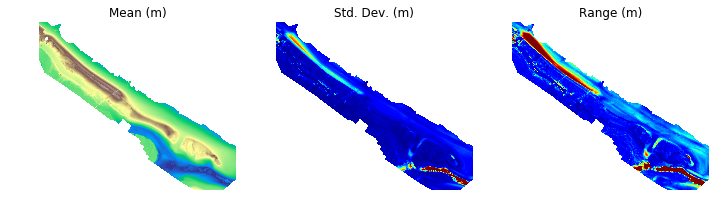

In [4]:
# Calculate mean and std. dev. of maps. Could do any numpy array statistics here, with or without NaNs
zmean = np.mean(zw,0)
zstd = np.std(zw,0)
zmin = np.min(zw,0)
zmax = np.max(zw,0)
zrange = zmax-zmin
plt.subplots(figsize=(12,6))
plt.subplot(1,3,1);plt.axis('off');plt.imshow(zmean[0::],cmap=plt.cm.terrain,vmin=-2,vmax=8)
plt.title('Mean (m)')
plt.subplot(1,3,2);plt.axis('off');plt.imshow(zstd[0::],cmap=plt.cm.jet,vmin=0,vmax=2)
plt.title('Std. Dev. (m)')
plt.subplot(1,3,3);plt.axis('off');plt.imshow(zrange[0::],cmap=plt.cm.jet,vmin=0,vmax=3)
plt.title('Range (m)')

In [5]:
# Refer to the last file opened to help define the output coord. ref. system and save as a "profile"
# Force the file type and array to be dtype="float32"
print(src.crs)
print(src.transform)
last_profile = {'driver': 'GTiff', 'height': ysize, 'width': xsize, 'count': 1,\
           'dtype': 'float32', 'crs':src.crs, 'transform': src.transform}
profile = {'driver': 'GTiff', 'height': ysize, 'width': xsize, 'count': 1,\
           'dtype': 'float32', 'crs':src.crs, 'transform': Affine(0.10, 0.00, e0, 0.00, -0.100, n0)}
print(last_profile)
print(profile)

print(zstd.dtype)

CRS({'init': 'epsg:6348'})
| 0.10, 0.00, 376304.92|
| 0.00,-0.10, 4625460.12|
| 0.00, 0.00, 1.00|
{'driver': 'GTiff', 'height': 6800, 'width': 8000, 'count': 1, 'dtype': 'float32', 'crs': CRS({'init': 'epsg:6348'}), 'transform': Affine(0.10000000000000203, 0.0, 376304.92252595216,
       0.0, -0.10000000000003725, 4625460.1194077525)}
{'driver': 'GTiff', 'height': 6800, 'width': 8000, 'count': 1, 'dtype': 'float32', 'crs': CRS({'init': 'epsg:6348'}), 'transform': Affine(0.1, 0.0, 376488.0,
       0.0, -0.1, 4625200.0)}
float64


In [6]:
# write the tiff files
with rasterio.open('zmean.tif', 'w',nodata=np.nan, **profile) as dst:
    dst.write(zmean.astype("float32"), indexes=1)
    dst.close()
    
with rasterio.open('zstd.tif', 'w', **profile) as dst:
    dst.write(zstd.astype("float32"), indexes=1)
    dst.close()
    
with rasterio.open('zrange.tif', 'w', **profile) as dst:
    dst.write(zrange.astype("float32"), indexes=1)
    dst.close()

In [7]:
# calculate the anomaly (map minus mean)
zanomaly = np.zeros_like(zw)
for i in range(nf):
    zanomaly[i,:,:] = zmean - zw[i,:,:]
    

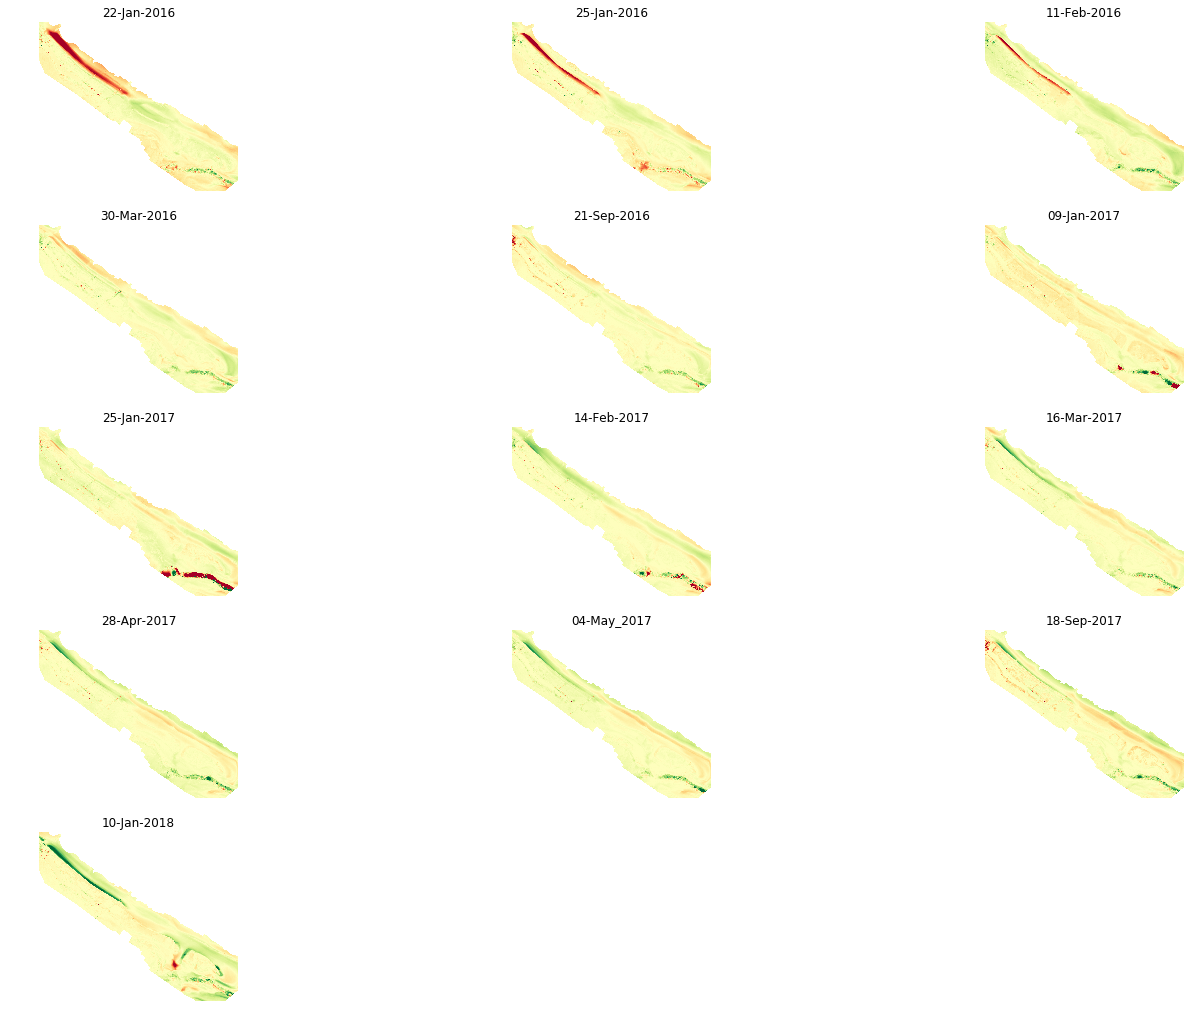

In [8]:
# plot and save the anomaly
# declare a plot size
plt.subplots(figsize=(24,18))
zimage = np.zeros((ysize,xsize))
for i in range(nf):
    zimage = np.squeeze(zanomaly[i,:,:])
    plt.subplot(5,3,i+1);plt.axis('off');plt.imshow(zimage,cmap=plt.cm.RdYlGn,vmin=-2,vmax=2)
    plt.title(titles[i])
    src.close()

    # write tif file
    fname = titles[i]+"_anomaly.tif"
    with rasterio.open(fname, 'w', nodata=np.nan,  **profile) as dst:
        dst.write(zimage.astype("float32"), indexes=1)
        dst.close()
        
plt.savefig('anomaly.png')

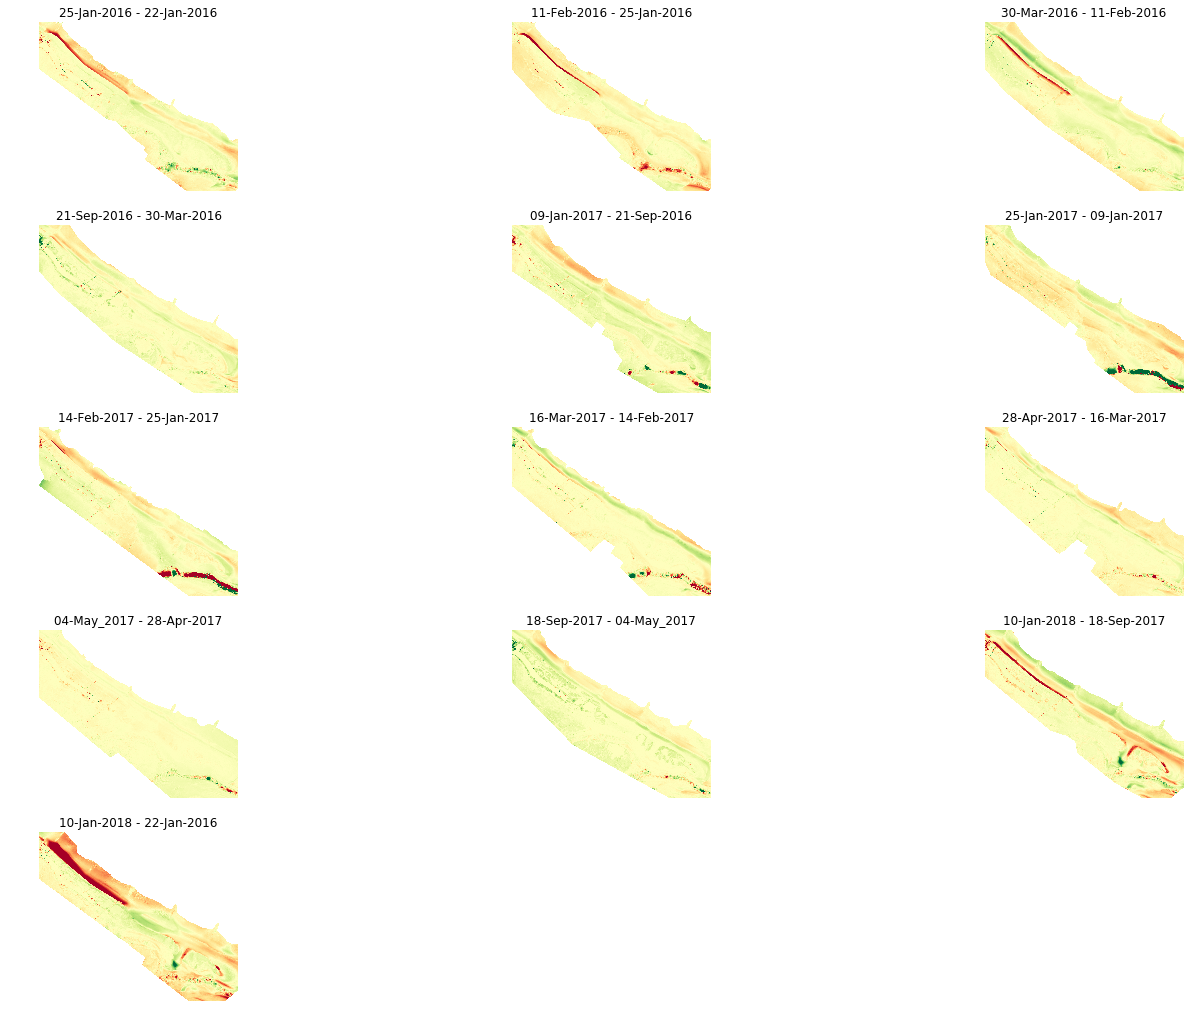

In [9]:
# calculate total change (last minus first)
ztdif = zw[nf-1][:][:]-zw[0][:][:]
fname = titles[nf-1]+"_minus_"+titles[0]+".tif"
with rasterio.open(fname, 'w', nodata=np.nan, **profile) as dst:
    dst.write(ztdif.astype("float32"), indexes=1)
    dst.close()

plt.subplots(figsize=(24,18))

# calculate array of differences and plot difference maps
zdiff = np.zeros((nf-1,ysize,xsize))
zd = np.zeros((ysize,xsize))
for i in range(nf-1):
    zd = zw[i+1][:][:]-zw[i][:][:]
    zdiff[i][:][:]=zd
    
    plt.subplot(5,3,i+1);plt.axis('off');plt.imshow(zd,cmap=plt.cm.RdYlGn,vmin=-2,vmax=2)
    plt.title(titles[i+1]+" - "+titles[i])

    fname = titles[i+1]+"_minus_"+titles[i]+".tif"
    with rasterio.open(fname, 'w', nodata=np.nan, **profile) as dst:
        dst.write(zd.astype("float32"), indexes=1)
        dst.close()
        
# plot final difference map
plt.subplot(5,3,nf);plt.axis('off');plt.imshow(ztdif,cmap=plt.cm.RdYlGn,vmin=-2,vmax=2)
plt.title(titles[nf-1]+" - "+titles[0])
    
plt.savefig('diff_maps.png')   

In [10]:
# just as a check: does the sum of the differences = diff of last - first?
zcheck = ztdif - np.sum(zdiff,0)
nmax = np.nanmax( zcheck )
print(nmax)

0.0


### Read in some coordinates for stable ground (parking lot, boulders in groins, etc.)

If these points are collectively low or high for a given map, then the map may be biased, and maybe the datum should be adjusted.

In [11]:
# Load in some points picked for low std. dev.
# read in the transect points
indir = "F:\\2018_Sandwich_Synthesis\\"
fname = "comparison_points.csv"
df=pd.read_csv(indir+fname, header = 0, skiprows=0, delimiter=',')
print("Read: ",len(df.index),' lines.')
df

Read:  17  lines.


,X,Y,LABEL
0,376693.025,4624926.512,Lot 1
1,376665.773,4624947.414,Lot 2
2,376743.164,4624875.050,Boardwalk 1
3,376625.556,4624977.047,Lot 3
4,376539.964,4625081.955,Lot 4
5,376512.182,4625115.160,Lot 5
6,376525.808,4625138.046,Bare ground 1
7,376555.971,4625167.547,Boulder 1
8,376568.539,4625180.909,Boulder 2
9,376691.305,4625043.193,Boulder 3


In [12]:
# bilinear interpolation
def bilint(z,en):
    """
    Bilinear interpolation into regular unit grid
    
    https://en.wikipedia.org/wiki/Bilinear_interpolation for a unit square
    
    Input:
       z - grid of values
       en - (c, r) tuple with column (x) and row (y) locations for the interpolation  
    """
    r = en[1]
    c = en[0]
    ir = np.int(r)
    ic = np.int(c)
    rx = r-ir
    cy = c-ic
    zi = z[ir,ic]*(1.-cy)*(1.-rx)+z[ir+1,ic]*cy*(1.-rx)+z[ir,ic+1]*(1.-cy)*rx+z[ir+1,ic+1]*rx*cy
    return zi

In [13]:
# set up an array to hold the results
numpts = df.shape[0]
zpts = np.nan*np.ones((numpts,nf))
print(np.shape(zpts))

(17, 13)


In [14]:
# loop through the list of comparison points
# use the transform for the window
transform= Affine(0.10, 0.00, e0, 0.00, -0.100, n0)
print(transform)
for index, row in df.iterrows():
    en = ~transform*(row["X"],row["Y"])
    #print( index, en )
    
    # loop through the maps
    for i in range(nf):
        # get elevation of point using bilinear interpolation in DEM
        try:
            zpts[index,i]=bilint(np.squeeze(zw[i,:,:]),en)
        except:
            print("interpolation problem")
                               
        #print(index,i,zpts[index,i])
        
pd.options.display.float_format = '{:,.2f}'.format        
df_pts = pd.DataFrame(data=zpts,index=df["LABEL"],columns=titles)
df_pts['Mean']=np.mean(zpts,axis=1)
df_pts['Std. Dev.']=np.std(zpts,axis=1)
display(df_pts)

| 0.10, 0.00, 376488.00|
| 0.00,-0.10, 4625200.00|
| 0.00, 0.00, 1.00|


,22-Jan-2016,25-Jan-2016,11-Feb-2016,30-Mar-2016,21-Sep-2016,09-Jan-2017,25-Jan-2017,14-Feb-2017,16-Mar-2017,28-Apr-2017,04-May_2017,18-Sep-2017,10-Jan-2018,Mean,Std. Dev.
LABEL,,,,,,,,,,,,,,,
Lot 1,2.80,2.78,2.75,2.76,2.74,2.81,2.63,2.74,2.72,2.70,2.68,2.69,2.77,2.74,0.05
Lot 2,2.63,2.65,2.56,2.62,2.58,2.66,2.49,2.63,2.59,2.58,2.54,2.53,2.65,2.59,0.05
Boardwalk 1,2.85,2.94,2.94,2.92,2.88,3.01,2.87,2.87,2.86,2.87,2.82,2.83,2.91,2.89,0.05
Lot 3,2.70,2.69,2.51,2.68,2.66,2.71,2.53,2.67,2.64,2.62,2.61,2.61,2.65,2.64,0.06
Lot 4,2.61,2.59,2.40,2.57,2.58,2.58,2.48,2.57,2.53,2.55,2.54,2.56,2.65,2.55,0.06
Lot 5,2.61,2.62,2.42,2.60,2.62,2.58,2.54,2.59,2.55,2.64,2.57,2.60,2.65,2.58,0.06
Bare ground 1,5.14,5.22,5.14,5.19,5.18,5.21,5.23,5.16,5.15,5.22,5.14,5.15,5.26,5.18,0.04
Boulder 1,1.73,1.76,1.74,1.72,1.72,1.77,1.82,1.75,1.75,1.72,1.72,1.70,1.77,1.74,0.03
Boulder 2,0.74,0.80,0.72,0.73,0.73,0.78,0.87,0.73,0.73,0.70,0.72,0.70,0.77,0.75,0.04


### Calculate anomaly for each point

(point value for each map minus the mean over all maps)

,22-Jan-2016,25-Jan-2016,11-Feb-2016,30-Mar-2016,21-Sep-2016,09-Jan-2017,25-Jan-2017,14-Feb-2017,16-Mar-2017,28-Apr-2017,04-May_2017,18-Sep-2017,10-Jan-2018,Mean,Std. Dev.
LABEL,,,,,,,,,,,,,,,
Lot 1,0.06,0.05,0.02,0.03,-0.00,0.07,-0.11,0.00,-0.01,-0.04,-0.05,-0.05,0.04,-0.00,0.05
Lot 2,0.04,0.05,-0.03,0.03,-0.01,0.06,-0.11,0.03,-0.01,-0.01,-0.05,-0.06,0.05,-0.00,0.05
Boardwalk 1,-0.04,0.05,0.05,0.03,-0.01,0.12,-0.02,-0.02,-0.03,-0.02,-0.07,-0.06,0.03,0.00,0.05
Lot 3,0.07,0.05,-0.13,0.04,0.02,0.07,-0.11,0.03,0.01,-0.02,-0.03,-0.03,0.01,0.00,0.06
Lot 4,0.06,0.04,-0.15,0.01,0.03,0.02,-0.08,0.01,-0.03,-0.00,-0.01,0.01,0.09,0.00,0.06
Lot 5,0.03,0.04,-0.17,0.01,0.04,-0.01,-0.05,0.00,-0.03,0.06,-0.01,0.01,0.07,-0.00,0.06
Bare ground 1,-0.05,0.04,-0.04,0.01,-0.01,0.03,0.05,-0.02,-0.04,0.04,-0.04,-0.03,0.07,-0.00,0.04
Boulder 1,-0.02,0.01,-0.01,-0.02,-0.02,0.02,0.08,0.00,0.00,-0.02,-0.02,-0.04,0.03,-0.00,0.03
Boulder 2,-0.01,0.05,-0.03,-0.02,-0.01,0.03,0.12,-0.02,-0.02,-0.04,-0.03,-0.05,0.02,0.00,0.04


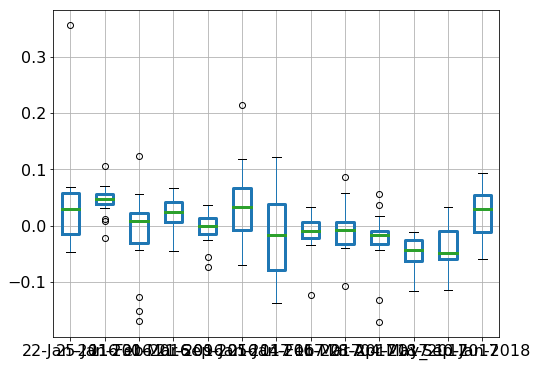

In [55]:
zpt_anom = np.nan*np.ones_like(zpts)
for i in range(numpts):
    zpt_anom[i,:] = zpts[i,:]-np.mean(zpts[i,:])

df3 = pd.DataFrame(data=zpt_anom,index=df["LABEL"],columns=titles)

boxprops = dict(linestyle='-', linewidth=3, color='k')
medianprops = dict(linestyle='-', linewidth=3, color='k')
bp=df3.boxplot(figsize=(8,6),fontsize=16,grid=True,boxprops=boxprops, medianprops=medianprops)
plt.savefig('unchanged_pts_boxplot.png',dpi=200)

zpts_anom_mean = np.mean(zpt_anom,axis=0)
zpts_anom_std = np.std(zpt_anom,axis=0)
df3.loc['Mean']=zpts_anom_mean
df3.loc['Std. Dev.']=zpts_anom_std
df3['Mean'] = df3.mean(numeric_only=True, axis=1)
df3['Std. Dev.'] = df3.std(numeric_only=True, axis=1)
display(df3)
df3.to_csv('unchanged_points.csv',sep=',')

In [16]:
df2 = pd.DataFrame(data=zpts_anom_mean.T,index=titles,columns=["Mean"])
df2['Std. Dev.']=zpts_anom_std.T
display(df2)

,Mean,Std. Dev.
22-Jan-2016,0.04,0.09
25-Jan-2016,0.04,0.03
11-Feb-2016,-0.01,0.07
30-Mar-2016,0.02,0.03
21-Sep-2016,-0.01,0.03
09-Jan-2017,0.04,0.06
25-Jan-2017,-0.02,0.07
14-Feb-2017,-0.01,0.03
16-Mar-2017,-0.01,0.04
28-Apr-2017,-0.03,0.05


In [39]:
# coordinates of the arrays
# top left corner of region of interest (UTM Zone 19N meters)
#e0 = 376488.; n0 = 4625200.

# size of roi (colums, rows). divide by 10 to get meters
# xsize, ysize = 8000, 6800
dx = 0.1
dy = 0.1
X,Y = np.meshgrid(np.linspace(e0,e0+xsize*dx,xsize),\
                  np.linspace(n0,n0-ysize*dy,ysize))

print(np.shape(X))
print(np.shape(zmean))
print(" Upper left: ",X[0][0],Y[0][0],'\n',"Lower right: ",X[-1][-1],Y[-1][-1])

(6800, 8000)
(6800, 8000)
 Upper left:  376488.0 4625200.0 
 Lower right:  377288.0 4624520.0


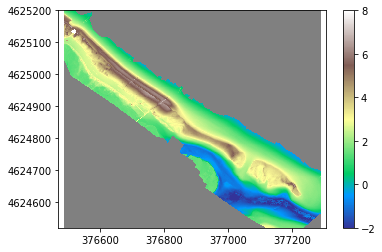

In [40]:
# a plot to check those coordinates
cmap=plt.cm.terrain
cmap.set_bad('grey')
plt.pcolormesh(X[0:-1:10],Y[0:-1:10],zmean[0:-1:10],shading='flat',edgecolor=None,cmap=cmap,vmin=-2,vmax=8)
plt.axis('equal')
plt.colorbar()

In [41]:
np.savez("sandwich_maps",X=X,Y=Y,zw=zw,zmean=zmean,zstd=zstd)